In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Sparsity Promoting Regularization (L1-regularization or Lasso regression)

L1-regularization is a method to prevent overfitting in linear models. It is also known as Lasso regression. It adds a penalty term to the loss function, which is the sum of the absolute values of the coefficients. This forces the coefficients to be small, and some of them to be exactly zero. This is useful for feature selection, as it allows to discard some of the features.

Suppose, we have the generalized linear model:

$$
y = w_0 + \mathbf{w}^T\boldsymbol{\phi}(x) + \epsilon.
$$

Note that we have added a bias term $w_0$ to the model. 
We want to fit the model to data $(x_i, y_i)$, where $x_i$ is the feature vector, and $y_i$ is the target variable. 

We can add the L1-regularization term to the usual sum of square errors loss function:

$$
L = \frac{1}{N}\sum_{i=1}^N(y_i - w_0 - \mathbf{w}^T\boldsymbol{\phi}{x_i})^2 + \lambda\|\mathbf{w}\|_1,
$$

where $\lambda$ is the regularization parameter.
The L1-norm of the vector $\mathbf{w}$ is defined as:

$$
\|\mathbf{w}\|_1 = \sum_{j=1}^M|w_j|.
$$

Notice that the bias term $w_0$ is not regularized.
We don't want to push it to zero, as it is a constant term, and it is not related to the features.

Let's cook up a simple example to illustrate the L1-regularization.
We will generate data from a polynomial of third order, and then try to fit a generalized linear model with a ton of terms. We will see that the L1-regularization will help us to discard some of the terms, and to select the most important ones.

Here are the data:

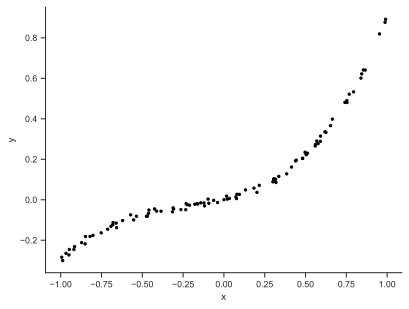

In [53]:
import numpy as np

num_samples = 100
f = lambda x: 0.2 * x + 0.3 * x**2 + 0.4 * x**3
sigma = 0.01
x = np.random.uniform(-1, 1, num_samples)
y = f(x) + np.random.normal(0, sigma, num_samples)

fig, ax = plt.subplots()
ax.plot(x, y, '.', color='k')
ax.set(xlabel='x', ylabel='y')
sns.despine();

We will try to fit a ridiculously complicated model.
We will have a twenty degree polynomial, and then we will also add a bunch of Fourier terms:

In [54]:
import jax.numpy as jnp
from jax import vmap

@vmap
def features(x):
    tmp1 = jnp.array([x ** i for i in range(10)])
    tmp2 = jnp.array([jnp.sin(2 * np.pi * x * i) for i in range(10)])
    return jnp.concatenate([tmp1, tmp2])

Visualize the features:

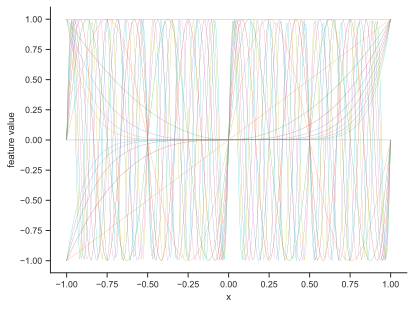

In [55]:
xs = jnp.linspace(-1, 1, 200)
Phi = features(xs)
fig, ax = plt.subplots()
ax.plot(xs, Phi, lw=0.2)
ax.set(xlabel='x', ylabel='feature value')
sns.despine();

Clearly an overkill. But Lasso regression will still be able to throw away the unnecessary terms.

In what follows we do Lasso regression using the `sklearn` library.
We use ``LassoCV``, which also does cross-validation to find the best value of the regularization parameter $\lambda$.

In [56]:
from sklearn import linear_model

Phi_train = features(x)
clf = linear_model.LassoCV(fit_intercept=False) 
clf.fit(Phi_train, y)

LassoCV(fit_intercept=False)

For comparison, we do Ridge regression (which adds an L2-regularization term) also with cross-validation.

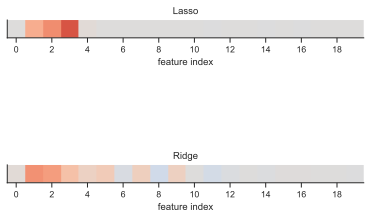

In [57]:
fig, axes = plt.subplots(2, 1)
axes[0].imshow(clf.coef_.reshape(1, 20), cmap='coolwarm', vmin=-0.5, vmax=0.5)
axes[0].set(xlabel='feature index', title='Lasso',
            xticks=np.arange(0, 20, 2), xticklabels=np.arange(0, 20, 2),
            yticks=[])
axes[0].set_title('Lasso')
axes[1].imshow(lr.coef_.reshape(1, 20), cmap='coolwarm', vmin=-0.5, vmax=0.5)
axes[1].set(xlabel='feature index', title='Ridge',
            xticks=np.arange(0, 20, 2), xticklabels=np.arange(0, 20, 2),
            yticks=[])
sns.despine();

We see that Ridge regression as a lot more non-zero coefficients than Lasso regression.

Let's visualize the predictions as well:

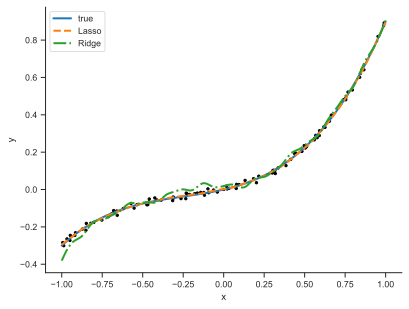

In [61]:
Phi_test = features(xs)
lass_pred = clf.predict(Phi_test)
ridge_pred = lr.predict(Phi_test)

fig, ax = plt.subplots()
ax.plot(x, y, '.', color='k')
ax.plot(xs, f(xs), lw=2, label='true')
ax.plot(xs, lass_pred, '--', lw=2, label='Lasso')
ax.plot(xs, ridge_pred, '-.', lw=2, label='Ridge')
ax.set(xlabel='x', ylabel='y')
ax.legend(loc='best')
sns.despine();

## How does it work?

To understand how Lasso regression works, we need to look at the L1-norm.
Let's work with just two parameters: $\mathbf{w} = (w_1,w_2)$.
The L1-norm is:

$$
\|\mathbf{w}\| = |w_1| + |w_2|.
$$

This is also called the Manhattan norm.
The reason behind the name is that it gives the distance between two points in a city block.

Let's consider a simple quadratic objective function:

$$
f(\mathbf{w}) = (\mathbf{w}-\mathbf{w}^*)^T\mathbf{A}(\mathbf{w}-\mathbf{w}^*),
$$

designed so that the minimum is at $\mathbf{w}^*$.
What is the minimum of the L1-regulatized objective function:

$$
g(\mathbf{w}) = f(\mathbf{w}) + \lambda\|\mathbf{w}\|_1?
$$

To understand this minimum, first we need to mention that Lasso regression is equivalent to the following constrained optimization problem:

$$
\min_{\mathbf{w}}f(\mathbf{w})\quad\text{subject to}\quad \|\mathbf{w}\|_1\leq t.
$$

To see that this is equivalent to the L1-regularized problem, we can use the Lagrange multiplier method.
One can show that there is a one-to-one correspondence between $\lambda$ and $t$.

Now, we can understand what is going on by looking at the level sets of $f(\mathbf{w})$ and $\|\mathbf{w}\|_1$.

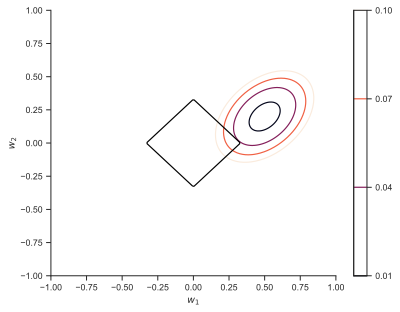

In [112]:
w_star = jnp.array([0.5, 0.2])
A = jnp.array([[1, -0.4], [-0.4, 1]])

from jax import jit

f = jit(vmap(lambda w: (w - w_star) @ A @ (w - w_star)))

w1 = jnp.linspace(-1, 1, 200)
w2 = jnp.linspace(-1, 1, 200)
W1, W2 = jnp.meshgrid(w1, w2)
W_flat = jnp.stack([W1.ravel(), W2.ravel()], axis=1)
f_flat = f(W_flat)
F = f_flat.reshape(200, 200)

l1_norm = jnp.linalg.norm(W_flat, ord=1, axis=1).reshape(200, 200)

fig, ax = plt.subplots()
contour = ax.contour(W1, W2, F, levels=np.linspace(0.01, 0.1, 4))
fig.colorbar(contour, ax=ax)
ax.set(xlabel='$w_1$', ylabel='$w_2$')

contour2 = ax.contour(W1, W2, l1_norm, levels=np.linspace(0, 0.33, 2), colors='k')
sns.despine();

Now think. You are trying to get to the minimum of $f(\mathbf{w})$
while remaining inside the level set of $\|\mathbf{w}\|_1 = t$.
The level sets of $\|\mathbf{w}\|_1$ are diamonds.
The minimum of $f(\mathbf{w})$ will be at the intersection of the level set of $f(\mathbf{w})$ and the diamond.
You will find your self at a corner of the diamond.
So one of the components of $\mathbf{w}$ will be zero.

## Bayesian Interpretation of Lasso Regression

Lasso regression can be interpreted as a Bayesian method.
To see this, put a Laplace prior on each one of the weights:

$$
w_j \sim \text{Laplace}(0, b).
$$

The PDF of the Laplace distribution is:

$$
p(w_j) = \frac{1}{2b}\exp\left(-\frac{|w_j|}{b}\right).
$$

Taking the logarithm of the Laplace prior, we get:

$$
\log p(w_j) = -\frac{|w_j|}{b} + \text{const}.
$$

Therefore, we see that (assuming a Gaussian likelihood), the L1-regularized objective function is (up to an additive constant) equal to the negative log posterior.